## 1. Import Standard Libraries

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F

## 2. Get the Data

In [6]:
mnist = pd.read_csv("Mnist_combined.csv",index_col = 0)

In [7]:
mnist.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Convert the Data into Tensor Dataset

In [8]:
X = mnist.drop(labels = "label" ,axis = 1)
Y = mnist["label"]

In [9]:
data_np = X.to_numpy()
labels_np = Y.to_numpy()

In [10]:
data_np[0].shape

(784,)

In [11]:
labels_np.shape

(70000,)

In [12]:
# normalize the data to a range of [0 1]
dataNorm = data_np / np.max(data_np)

In [13]:
dataNorm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Hist- visualization

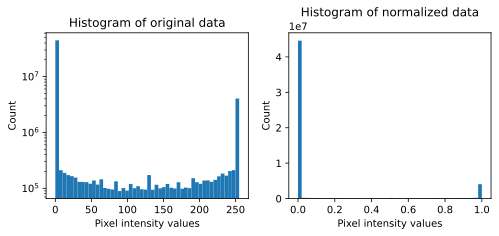

In [14]:
fig,ax = plt.subplots(1,2,figsize=(8,3) ,dpi = 130 )

ax[0].hist(data_np.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale("log")

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

#### Converting Numpy array to Pytorch Array

In [15]:
# convert to a pytorch tensor
data = torch.tensor(data_np).float()

# Note: "long" format for CCE : Multiclass classification
labels = torch.tensor(labels_np).long() 

#### Train and Test Loader

In [16]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [17]:
# scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects

batchsize    = 64
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True  ,drop_last=True)
test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0] ) 

## 4. Create the ANN model

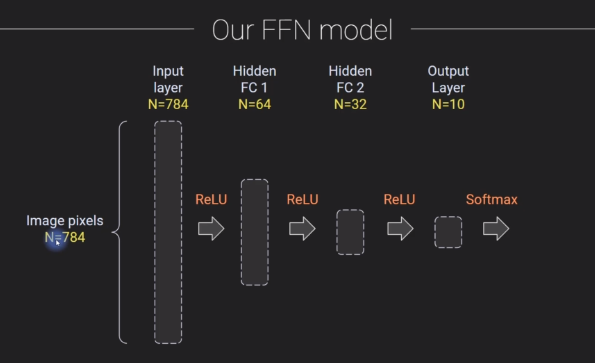

In [18]:
# create a class for the model
def createTheMNISTNet(LR):

    class MNISTNet(nn.Module):
        
        def __init__(self):
            super().__init__()

            ### Input layer
            self.input = nn.Linear(784,64)

            ### Hidden layer-1
            self.fc1 = nn.Linear(64,32)
            
            ### Hidden Layer-2
            self.fc2 = nn.Linear(32,32)

            ### Output layer
            self.output = nn.Linear(32,10)

        # forward pass
        def forward(self,x):
            
            # Input  Layer
            x = F.relu( self.input(x) ) 
            # Hidden Layer-1
            x = F.relu( self.fc1(x) )
            # Hidden Layer-2
            x = F.relu(self.fc2(x))
            
            return torch.log_softmax( self.output(x),axis=1 )
        
    # create the model instance
    ANN_model = MNISTNet()

    # loss function : Negative Log-Likelihood Loss function
    lossfunc = nn.NLLLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANN_model.parameters(),lr=LR)

    return ANN_model,lossfunc,optimizer

## 5. Model Training

In [19]:
def function2trainTheModel(Model , lossfunc , optimizer ,train_loader , test_loader , epochs):

    losses   = torch.zeros(epochs)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(epochs):

        # switch on training mode
        Model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
    
        # Batch Training
        for X,y in train_loader:

            # Forward pass and loss
            yHat_train = Model(X)
            loss = lossfunc(yHat_train,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batchLoss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(yHat_train,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append( accuracyPct )               # add to list of accuracies
        # End of batch loop...

        # Now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.round(np.mean(batchAcc),2 ))

        # Get average losses across the batches
        losses[epochi] = np.round(np.mean(batchLoss),2)

        # test accuracy
        Model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():         # deactivates autograd
            yHat_test = Model(X)
      
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( np.round(100*torch.mean((torch.argmax(yHat_test,axis=1)==y).float()),2 ) )
        # End epochs

    # function output
    return trainAcc,testAcc,losses,Model


## 6.  Run the model and plot the results

In [20]:
ANN_model,lossfunc,optimizer = createTheMNISTNet(LR = 0.01)

In [21]:
# 10 mins time it took 
TrainAcc,TestAcc,Losses,trained_Model = function2trainTheModel(Model = ANN_model , 
                                                               lossfunc = lossfunc , 
                                                               optimizer  = optimizer,
                                                               train_loader = train_loader , 
                                                               test_loader  =  test_loader, 
                                                               epochs = 50)

## 7. Results Visualization

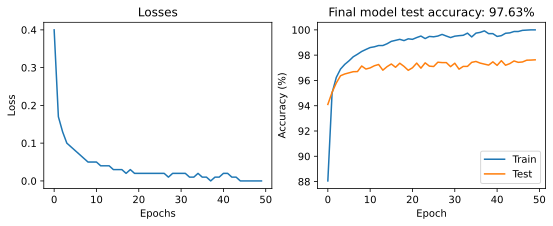

In [22]:
fig,ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot(Losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses')

ax[1].plot(TrainAcc,label='Train')
ax[1].plot(TestAcc, label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title(f'Final model test accuracy: {TestAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

## 8. Save the trained model

In [24]:
trained_Model.state_dict()

OrderedDict([('input.weight',
              tensor([[ 0.0101, -0.0308,  0.0269,  ...,  0.0018,  0.0065,  0.0024],
                      [ 0.0112, -0.0077,  0.0012,  ...,  0.0165,  0.0226, -0.0192],
                      [ 0.0207, -0.0256, -0.0081,  ...,  0.0035,  0.0067,  0.0150],
                      ...,
                      [ 0.0303, -0.0087, -0.0092,  ...,  0.0144, -0.0180,  0.0288],
                      [ 0.0208, -0.0035,  0.0207,  ...,  0.0298, -0.0049,  0.0343],
                      [ 0.0014,  0.0289, -0.0101,  ...,  0.0107, -0.0138, -0.0190]])),
             ('input.bias',
              tensor([ 0.0014,  0.0324,  0.0121,  0.0073, -0.0316,  0.0105,  0.0242, -0.0269,
                      -0.0127, -0.0212, -0.0317,  0.0036,  0.0180,  0.0247, -0.0208, -0.0269,
                       0.0246, -0.0124, -0.0316, -0.0098,  0.0339, -0.0237, -0.0267, -0.0228,
                      -0.0228, -0.0002, -0.0160, -0.0076, -0.0098,  0.0254,  0.0068, -0.0095,
                      -0.0036,  

In [25]:
torch.save(trained_Model.state_dict(), "Mnist_trained_model.pt")

## 9. Load the model under a different name

In [26]:
# Create two new models of the same class
model1 = createTheMNISTNet(LR = 0.01)[0]
model2 = createTheMNISTNet(LR = 0.01)[0]

In [30]:
torch.load('Mnist_trained_model.pt')

OrderedDict([('input.weight',
              tensor([[ 0.0101, -0.0308,  0.0269,  ...,  0.0018,  0.0065,  0.0024],
                      [ 0.0112, -0.0077,  0.0012,  ...,  0.0165,  0.0226, -0.0192],
                      [ 0.0207, -0.0256, -0.0081,  ...,  0.0035,  0.0067,  0.0150],
                      ...,
                      [ 0.0303, -0.0087, -0.0092,  ...,  0.0144, -0.0180,  0.0288],
                      [ 0.0208, -0.0035,  0.0207,  ...,  0.0298, -0.0049,  0.0343],
                      [ 0.0014,  0.0289, -0.0101,  ...,  0.0107, -0.0138, -0.0190]])),
             ('input.bias',
              tensor([ 0.0014,  0.0324,  0.0121,  0.0073, -0.0316,  0.0105,  0.0242, -0.0269,
                      -0.0127, -0.0212, -0.0317,  0.0036,  0.0180,  0.0247, -0.0208, -0.0269,
                       0.0246, -0.0124, -0.0316, -0.0098,  0.0339, -0.0237, -0.0267, -0.0228,
                      -0.0228, -0.0002, -0.0160, -0.0076, -0.0098,  0.0254,  0.0068, -0.0095,
                      -0.0036,  

In [28]:
# Replace one model's parameters with those of the trained net
model1.load_state_dict(torch.load('Mnist_trained_model.pt'))

<All keys matched successfully>

# Show that the two models are the same

In [32]:
# get some data from the test loader
X,y = next(iter(test_loader))

# run the data through both models
yHatNet    = trained_Model(X)
yHatModel1 = model1(X)
yHatModel2 = model2(X)

In [35]:
yHatNet[0]

tensor([-35.7967, -50.6831, -58.5043, -55.6616, -24.9552, -34.0503,   0.0000,
        -58.5426, -41.7616, -66.4492], grad_fn=<SelectBackward0>)

In [36]:
yHatModel1[0]

tensor([-35.7967, -50.6831, -58.5043, -55.6616, -24.9552, -34.0503,   0.0000,
        -58.5426, -41.7616, -66.4492], grad_fn=<SelectBackward0>)

In [37]:
yHatModel2[0]

tensor([-8.0051, -0.0610, -4.5993, -5.0867, -8.7840, -3.8609, -6.0235, -4.2739,
        -6.2349, -5.7839], grad_fn=<SelectBackward0>)

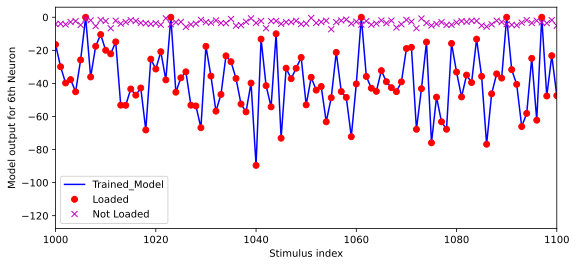

In [42]:
# show that the results overlap

fig = plt.figure(figsize=(9,4) ,dpi = 145)

plt.plot(yHatNet[:,5].detach(),'b',label='Trained_Model')
plt.plot(yHatModel1[:,5].detach(),'ro',label='Loaded')
plt.plot(yHatModel2[:,5].detach(),'mx',label='Not Loaded')

plt.legend()

plt.xlabel('Stimulus index')
plt.ylabel('Model output for 6th Neuron')
plt.xlim([1000,1100])

plt.show()